# Services planning

In [1]:
import pandas as pd

blocks = pd.read_pickle('./blocks.pickle')
columns = [c for c in blocks.columns if 'capacity_' in c]
blocks = blocks[['geometry', 'population', 'site_area', 'land_use', 'is_project', *columns]].copy()
blocks.head(3)

,geometry,population,site_area,land_use,is_project,capacity_bakery,capacity_bank,capacity_bar,capacity_cafe,capacity_dog_park,...,capacity_polyclinic,capacity_religion,capacity_restaurant,capacity_school,capacity_stadium,capacity_supermarket,capacity_swimming_pool,capacity_train_station,capacity_university,capacity_veterinary
0,"POLYGON ((388726.347 6637020.627, 388713.674 6...",2.0,2.127981e+07,None,NaN,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((388713.674 6637030.346, 388726.347 6...",0.0,5.171425e+01,None,NaN,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((374726.595 6642638.322, 374534.487 6...",491.0,7.593088e+07,None,NaN,0.0,0.0,0.0,500.0,0.0,...,0,0.0,0.0,0,0.0,0.0,0.0,0.0,120.0,0.0


In [2]:
accessibility_matrix = pd.read_pickle('./accessibility_matrix.pickle')
accessibility_matrix.head()

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,0,1,2,3,4,5,6,7,8,9,...,2643,2644,2645,2646,2647,2648,2649,2650,2651,2652
0,0.00000,35.375,188.0000,168.500,116.6250,140.50000,114.2500,162.1250,107.750000,110.687500,...,91.75000,91.5000,91.31250,91.25000,90.8125,90.43750,90.93750,91.75000,68.12500,86.5625
1,34.65625,0.000,155.8750,136.375,84.5625,108.50000,82.1875,130.0000,75.625000,78.562500,...,59.71875,59.4375,59.28125,59.21875,58.8125,58.40625,58.90625,59.71875,36.09375,54.5000
2,191.87500,159.125,0.0000,105.875,113.9375,154.50000,128.2500,176.2500,121.812500,124.750000,...,159.75000,159.5000,159.25000,159.25000,158.8750,158.50000,159.00000,158.12500,136.12500,152.8750
3,171.12500,138.250,105.8750,0.000,171.6250,209.50000,186.0000,233.7500,179.375000,182.375000,...,139.00000,138.6250,138.50000,138.50000,138.0000,137.62500,138.12500,137.25000,115.31250,132.1250
4,118.75000,85.875,113.3125,175.250,0.0000,47.90625,21.6875,69.5625,15.148438,18.109375,...,117.31250,117.0625,116.87500,116.87500,116.4375,116.06250,116.50000,116.87500,93.75000,111.6875


176

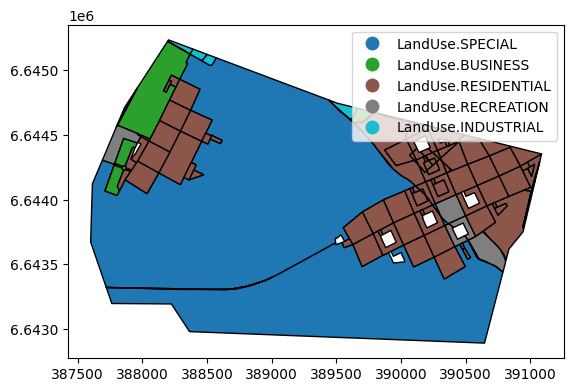

In [3]:
blocks[blocks.is_project == True].plot('land_use', legend=True, edgecolor='black')
len(blocks[blocks.is_project == True])

### Service distribution

In [4]:
basic_services = {
    "kindergarten": 0.2,
    "school": 0.2,
    "pharmacy": 0.2,
    "polyclinics": 0.3,
    "convenience": 0.2,   
    "cafe": 0.15,
    "playground": 0.2,
    "post": 0.1,
    "hairdresser": 0.1
}
advanced_services = {
    "hospital": 0.5,
    "supermarket": 0.4,
    "restaurant": 0.3,
    "park": 0.8,
    "bank": 0.3,
    "fuel": 0.25,
    "police": 0.2,
    "cinema": 0.2,
    "market": 0.2,
    "religion": 0.5,
    "multifunctional_center": 0.1,
    "train_building": 0.1,
    "cemetery": 0.1,
    "notary": 0.1,
    "pitch": 0.2
}
comfort_services = {
    "mall": 0.3,
    "swimming_pool": 0.4,
    "theatre": 0.2,
    "museum": 0.2,
    "university": 0.2,
    "sanatorium": 0.2,
    "zoo": 0.1,
    "reserve": 0.1,
    "animal_shelter": 0.1,
    "aeroway_terminal": 0.2,
    "crematorium": 0.1,
    "prison": 0.1,
    "landfill": 0.1,
    "bar": 0.3,
    "hotel": 0.3,
}


def get_service_weight(service_name):
    if service_name in basic_services:
        return 0.5714 * basic_services[service_name]
    elif service_name in advanced_services:
        return 0.2857 * advanced_services[service_name]
    elif service_name in comfort_services:
        return 0.1429 * comfort_services[service_name]
    return 0

### Service types and weights

In [5]:
chosen_service_types = set(basic_services) | set(advanced_services) | set(comfort_services)
service_weights = {service_type: get_service_weight(service_type) for service_type in chosen_service_types if f'capacity_{service_type}' in blocks.columns}

### Select ID of optimized blocks

In [6]:
from blocksnet.enums import LandUse
from blocksnet.config import service_types_config


def get_land_use_min_site_area(lu : LandUse):
    land_use_df = service_types_config.land_use
    units_df = service_types_config.units

    land_use_s = land_use_df[lu]
    lu_service_types = land_use_s[land_use_s].index.to_list()

    lu_units = units_df[units_df.service_type.isin(lu_service_types) & units_df.service_type.isin(chosen_service_types)]
    return lu_units[lu_units.site_area > 0].site_area.min()

min_site_areas = {lu:get_land_use_min_site_area(lu) for lu in LandUse}

blocks_lu = {}
for block_id,row in blocks.iterrows():
    if row.is_project == True and row.land_use is not None:
        min_site_area = min_site_areas[row.land_use]
        if min_site_area>row.site_area*0.8:
            continue
        blocks_lu[block_id] = row.land_use
len(blocks_lu)

130

### Initialize and run optimizer

In [7]:
from blocksnet.optimization.services import (
    TPEOptimizer,
    WeightedObjective,
    WeightedConstraints,
    Facade,
    GradientChooser,
    RandomOrder,
    AreaSolution
)

MAX_TIME_SEC = 60*5
MAX_PROV_EVALS = 100
MAX_OPT_RUNS = 1000

In [11]:
var_adapter = AreaSolution(blocks_lu)

facade = Facade(
    blocks_lu=blocks_lu,
    blocks_df=blocks,
    accessibility_matrix=accessibility_matrix,
    var_adapter=var_adapter,
)

from tqdm import tqdm

for service_type, weight in tqdm(service_weights.items()):
    facade.add_service_type(service_type, weight, blocks.rename(columns={f'capacity_{service_type}': 'capacity'})[['capacity']].fillna(0))

objective = WeightedObjective(num_params=facade.num_params, facade=facade, weights=service_weights, max_evals=MAX_PROV_EVALS)

constraints = WeightedConstraints(num_params=facade.num_params, facade=facade, priority=service_weights)

100%|██████████| 21/21 [00:07<00:00,  2.89it/s]


In [12]:
tpe_optimizer = TPEOptimizer(
    objective=objective, constraints=constraints, vars_order=RandomOrder(), vars_chooser=GradientChooser(facade, num_params=facade.num_params, num_top=5)
)

best_x, best_val, perc, func_evals = tpe_optimizer.run(max_runs=MAX_OPT_RUNS, timeout=MAX_TIME_SEC, initial_runs_num=1)

[I 2025-09-25 19:49:21,212] A new study created in memory with name: no-name-adea122e-ad09-4c4c-b258-587d9cbc3883


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-09-25 19:50:04,439] Trial 0 finished with value: 1.70666108849601 and parameters: {'x_499': 0, 'x_999': 0, 'x_95': 60, 'x_1771': 0, 'x_2140': 0, 'x_1057': 150, 'x_641': 270, 'x_433': 0, 'x_928': 450, 'x_1697': 0, 'x_1173': 0, 'x_1540': 0, 'x_1995': 0, 'x_966': 450, 'x_673': 200, 'x_701': 0, 'x_603': 270, 'x_596': 200, 'x_2249': 0, 'x_2171': 0, 'x_2228': 0, 'x_1026': 150, 'x_18': 60, 'x_765': 0, 'x_412': 0, 'x_690': 0, 'x_1876': 0, 'x_1909': 0, 'x_1474': 0, 'x_2033': 0, 'x_1793': 0, 'x_1213': 0, 'x_1836': 700, 'x_1565': 0, 'x_1361': 0, 'x_134': 100, 'x_1000': 0, 'x_2057': 0, 'x_576': 200, 'x_1624': 0, 'x_511': 0, 'x_944': 450, 'x_456': 0, 'x_526': 0, 'x_1638': 0, 'x_1597': 0, 'x_496': 0, 'x_1904': 700, 'x_1612': 0, 'x_141': 100, 'x_1905': 700, 'x_1206': 0, 'x_1014': 0, 'x_70': 0, 'x_1469': 0, 'x_489': 30000, 'x_1585': 0, 'x_275': 0, 'x_894': 0, 'x_372': 0, 'x_572': 270, 'x_2191': 0, 'x_785': 0, 'x_135': 100, 'x_1606': 0, 'x_1754': 0, 'x_235': 2000, 'x_442': 0, 'x_1023': 150, 'x_

Convert to services dataframe

In [36]:
solution_df = facade.solution_to_services_df(best_x)
solution_df

,block_id,service_type,site_area,build_floor_area,capacity,count
12,2481,market,3000.0,6000.0,3000,1
28,2485,market,3000.0,6000.0,3000,1
40,2488,market,3000.0,6000.0,3000,1
46,2489,market,6000.0,12000.0,8000,1
80,2500,market,3000.0,6000.0,3000,1
...,...,...,...,...,...,...
10739,2619,playground,50.0,0.0,20,1
10742,2620,playground,50.0,0.0,20,1
10745,2622,playground,50.0,0.0,20,1
10748,2623,playground,50.0,0.0,20,1


Extract area dataframe from solution

In [9]:
solution_area_df = facade.get_solution_area_df(best_x)
solution_area_df.to_csv(f'solution_area.csv')
solution_area_df.loc[blocks_lu.keys()]

,population,build_floor_area,living_area,footprint_area
2477,0.0,515564.859674,0.000000,103112.971935
2478,0.0,54367.675735,0.000000,0.000000
2479,27.0,5554.606210,294.606210,987.485548
2480,1541.0,31312.721131,16512.721131,5566.705979
2481,3759.0,61444.753533,40284.753533,10923.511739
...,...,...,...,...
2648,0.0,43.745961,3.745961,7.777060
2649,3.0,104.006643,34.006643,18.490070
2650,7.0,225.528632,80.528632,40.093979
2651,0.0,888.350229,0.000000,94.757358


In [37]:
solution_area_df.population.sum()

np.float64(57202.0)

### Visualization

In [10]:
import matplotlib.pyplot as plt


def plot_df(df):
    df_called_obj = df.loc[df["called_obj"] == True]

    plt.scatter(df_called_obj["func_evals"], df_called_obj["best_val"], c="red", s=5)

    df_called_obj = pd.concat(
        [pd.DataFrame([[-1, None, 0, 0, None, 0, False, 0]], columns=df_called_obj.columns), df_called_obj]
    )
    plt.plot(
        df_called_obj["func_evals"], df_called_obj["best_val"], label="Best Value (TPE)", color="blue", linewidth=1
    )
    # Добавление точек с цветом в зависимости от 'called_obj'
    # Настройка осей и заголовка
    plt.xlabel("Number of objective evaluation")
    plt.ylabel("Best Value")
    plt.title("Best Value Across Trials")
    plt.legend()
    plt.grid(True)

    # Отображение графика
    plt.show()

In [17]:
tpe_df

,best_val,provisions
0,1.709001,"{'market': 1.0, 'hotel': 1.0, 'bar': 1.0, 'pit..."
1,1.709001,"{'bar': 1.0, 'hotel': 1.0, 'park': 1.0, 'super..."


In [22]:
tpe_df

,best_val,provisions
0,1.709001,"{'market': 1.0, 'hotel': 1.0, 'bar': 1.0, 'pit..."
1,1.709001,"{'bar': 1.0, 'hotel': 1.0, 'park': 1.0, 'super..."


In [21]:
import pandas as pd

tpe_df = pd.read_csv("provisions.csv")
plot_df(tpe_df)

KeyError: 'called_obj'

In [24]:
facade.save_delta_demand(best_x)
population_df = pd.read_csv("demand_services.csv")
population_df.head(20)

,Block id,Service type,Demand
0,39,swimming_pool,0
1,39,park,0
2,39,university,0
3,39,police,0
4,39,multifunctional_center,0
5,39,museum,0
6,39,hotel,0
7,39,pitch,0
8,61,swimming_pool,0
9,61,park,0
